# Strain mapping of experimental partially cycled Li$_x$FePO$_4$ nanoplatelets

This notebooks measures the strain fields of an experimental 4D-STEM dataset which consists of a thick (several hundred nanometer) Li$_x$FePO$_4$ nanoplatelet, imaged along the [010] direction, which has been partially electrochemically cycled.

During electrochemical cycling lithium atoms move in and out of the crystal, with the lattice responding to these changes in chemistry.  As lithium is removed, the longer $a$-direction contracts and the shorter $c$-direction expands.  As lithium replaced in the lattice the process reverses.  Here, we look at the micro- and nano-structure of a particle that has been partially cycled once from it's pristine, fully lithiated state.


---

## Data

You can download the tutorial dataset here: (265 megabytes)
* [Partially cycled Li$_x$FePO$_4$ 4D-STEM data](https://drive.google.com/file/d/1uYB23czoa7U05CtHVx9zfiVQFjiPfJUy/view?usp=drive_link)


### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Ben Savitzky (bhsavitzky@lbl.gov)
- Stephanie Ribet (sribet@lbl.gov)

Experimental data was collected by Lauren Hughes.  For more on this system and dataset, see
- Hughes, L. A., et al. "Correlative analysis of structure and chemistry of LixFePO4 platelets using 4D-STEM and X-ray ptychography." Materials Today 52 (2022): 102-111.
- Deng, Haitao D., et al. "Correlative image learning of chemo-mechanics in phase-transforming solids." Nature Materials 21.5 (2022): 547-554.

Updated 11/1/2023

In [1]:
# Imports
import py4DSTEM
from py4DSTEM import show
import numpy as np
import matplotlib.pyplot as plt
print('py4DSTEM version: {}'.format(py4DSTEM.__version__))

py4DSTEM version: 0.14.9


# Load data

In [2]:
# Set the filepath

# first set the path to the directory...
dirpath = "/Users/Ben/work/data/py4DSTEM_sampleData/LFP/"

# ...then append the filename to that path
filepath_data = dirpath + "Particle_1_Stack_1_45x90_ss30nm_0p09s_spot8_alpha=0p48_bin2_cl-600mm_300kV_bin8.h5"

In [3]:
# Examine the file contents

py4DSTEM.print_h5_tree( filepath_data )

/
|---datacube_root
    |---datacube




In [4]:
# Load data
datacube = py4DSTEM.read( filepath = filepath_data )

# print results
print(datacube)

DataCube( A 4-dimensional array of shape (90, 45, 128, 128) called 'datacube',
          with dimensions:

              Rx = [0.0,49.5,99.0,...] nm
              Ry = [0.0,49.5,99.0,...] nm
              Qx = [0,1,2,...] pixels
              Qy = [0,1,2,...] pixels
)


# Examine the data 

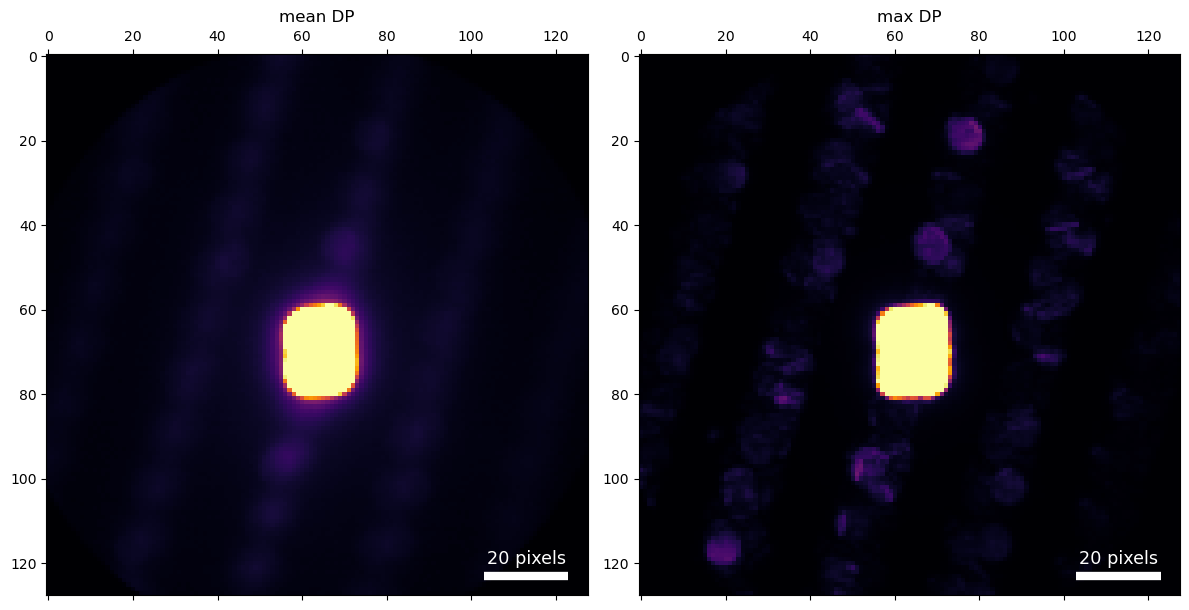

In [5]:
# Mean and max diffraction pattern of the calibration and measurement datasets

# compute
dp_mean = datacube.get_dp_mean()
dp_max = datacube.get_dp_max()

# show
show(
    [dp_mean,dp_max],
    cmap = 'inferno',
    title = ['mean DP','max DP']
)

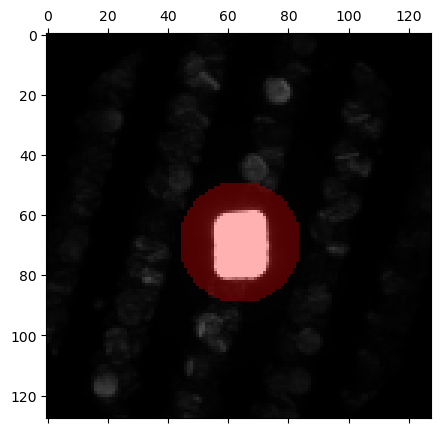

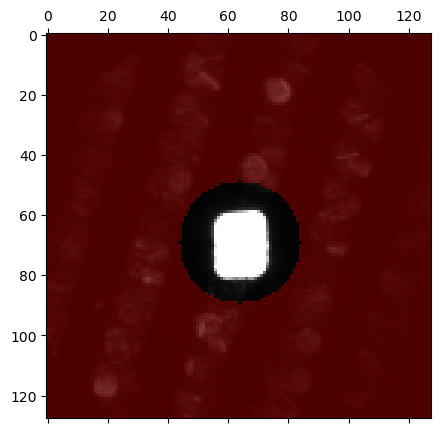

In [6]:
# Virtual imaging - position the detectors


# We'll generate a bright-field (BF) and an annular dark-field (ADF) virtual image
# for both the calibration and measurement datasets


# Set the center
center = (69,64)


# set the geometries
radius_bf = 20
geometry_bf = (center,radius_bf)
geometry_adf = (center,(radius_bf,10e3))

# display the detector positions
datacube.position_detector(
    data = dp_max,
    mode = 'circle',
    geometry = geometry_bf
)
datacube.position_detector(
    data = dp_max,
    mode = 'annulus',
    geometry = geometry_adf
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4050/4050 [00:00<00:00, 29196.55it/s]


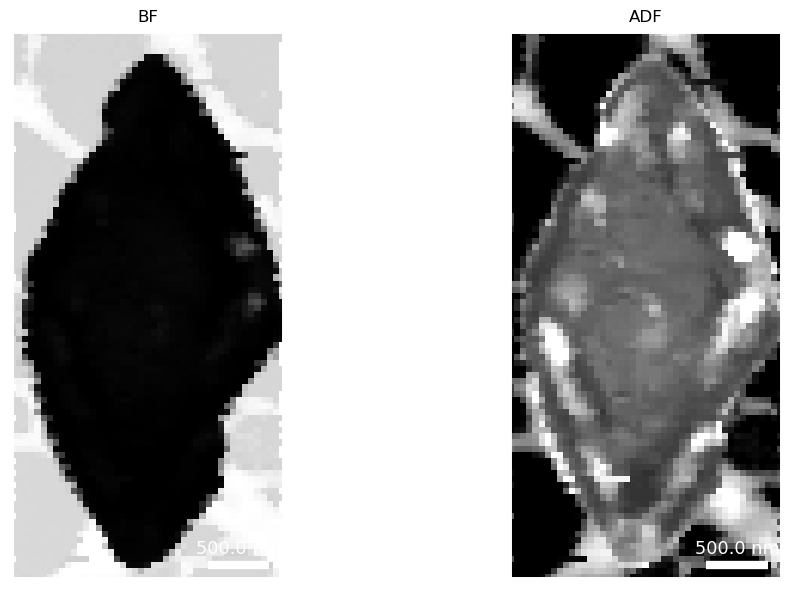

In [7]:
# Virtual imaging - compute the images


# compute
im_bf = datacube.get_virtual_image(
    mode = 'circle',
    geometry = geometry_bf,
    name = 'bright_field_cal',
)
im_adf = datacube.get_virtual_image(
    mode = 'annulus',
    geometry = geometry_adf,
    name = 'dark_field_cal',
)

# show
py4DSTEM.show(
    [im_bf,im_adf],
    figsize=(16,2),
    bordercolor = 'w',
    cmap='gray',
    title=['BF','ADF']
)

# Construct probe template

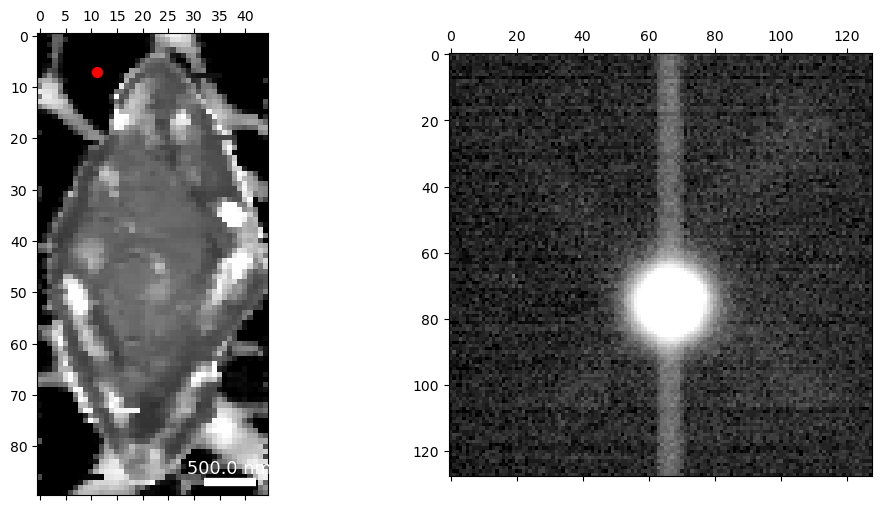

In [8]:
# Examine scan points for a vacuum probe

rx,ry = 7,11

py4DSTEM.visualize.show_selected_dp(
    datacube,
    im_adf,
    rx,
    ry
)

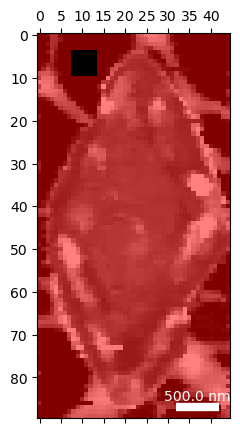

In [9]:
# Select a vacuum region

xlims = 4,10
ylims = 8,14

ROI = np.zeros(datacube.rshape, dtype=bool)
ROI[xlims[0]:xlims[1], ylims[0]:ylims[1]] = True

show(
    im_adf,
    mask = ROI,
    mask_color = 'r',
    mask_alpha = 0.5
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 349.51it/s]


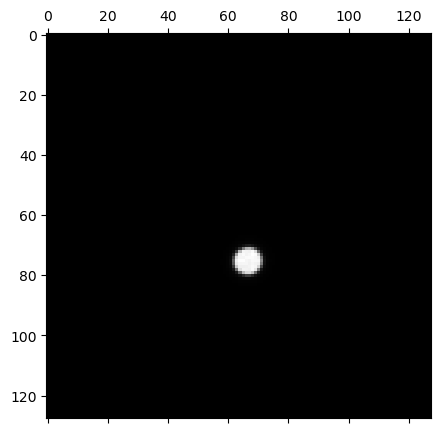

In [10]:
probe = datacube.get_vacuum_probe(
    ROI = ROI,
)

show(
    probe.probe,
    vmin=0,
    vmax=1,
)

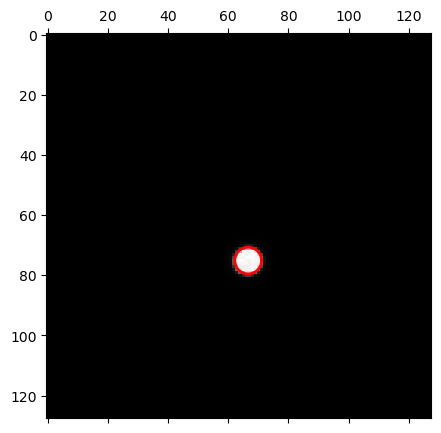

In [11]:
# Estimate the radius of the BF disk

probe_semiangle, probe_qx0, probe_qy0 = py4DSTEM.process.calibration.get_probe_size(probe.probe)

show(
    probe.probe,
    circle = {
        'center' : (probe_qx0,probe_qy0),
        'R' : probe_semiangle,
    },
    vmin = 0,
    vmax = 1
)

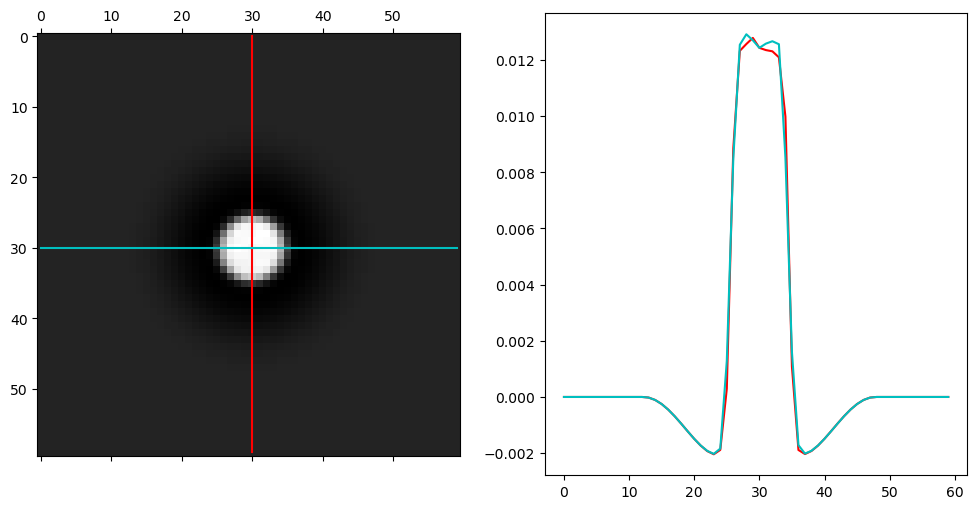

In [12]:
probe.get_kernel(
    mode = 'sigmoid',
    origin = (probe_qx0,probe_qy0),
    radii = (probe_semiangle * 1,
             probe_semiangle * 4
    )
)

py4DSTEM.visualize.show_kernel(
    probe.kernel,
    R = 30,
    L = 30,
    W = 1
)

# Find Bragg Peaks

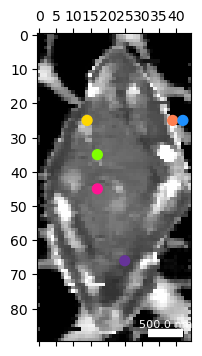

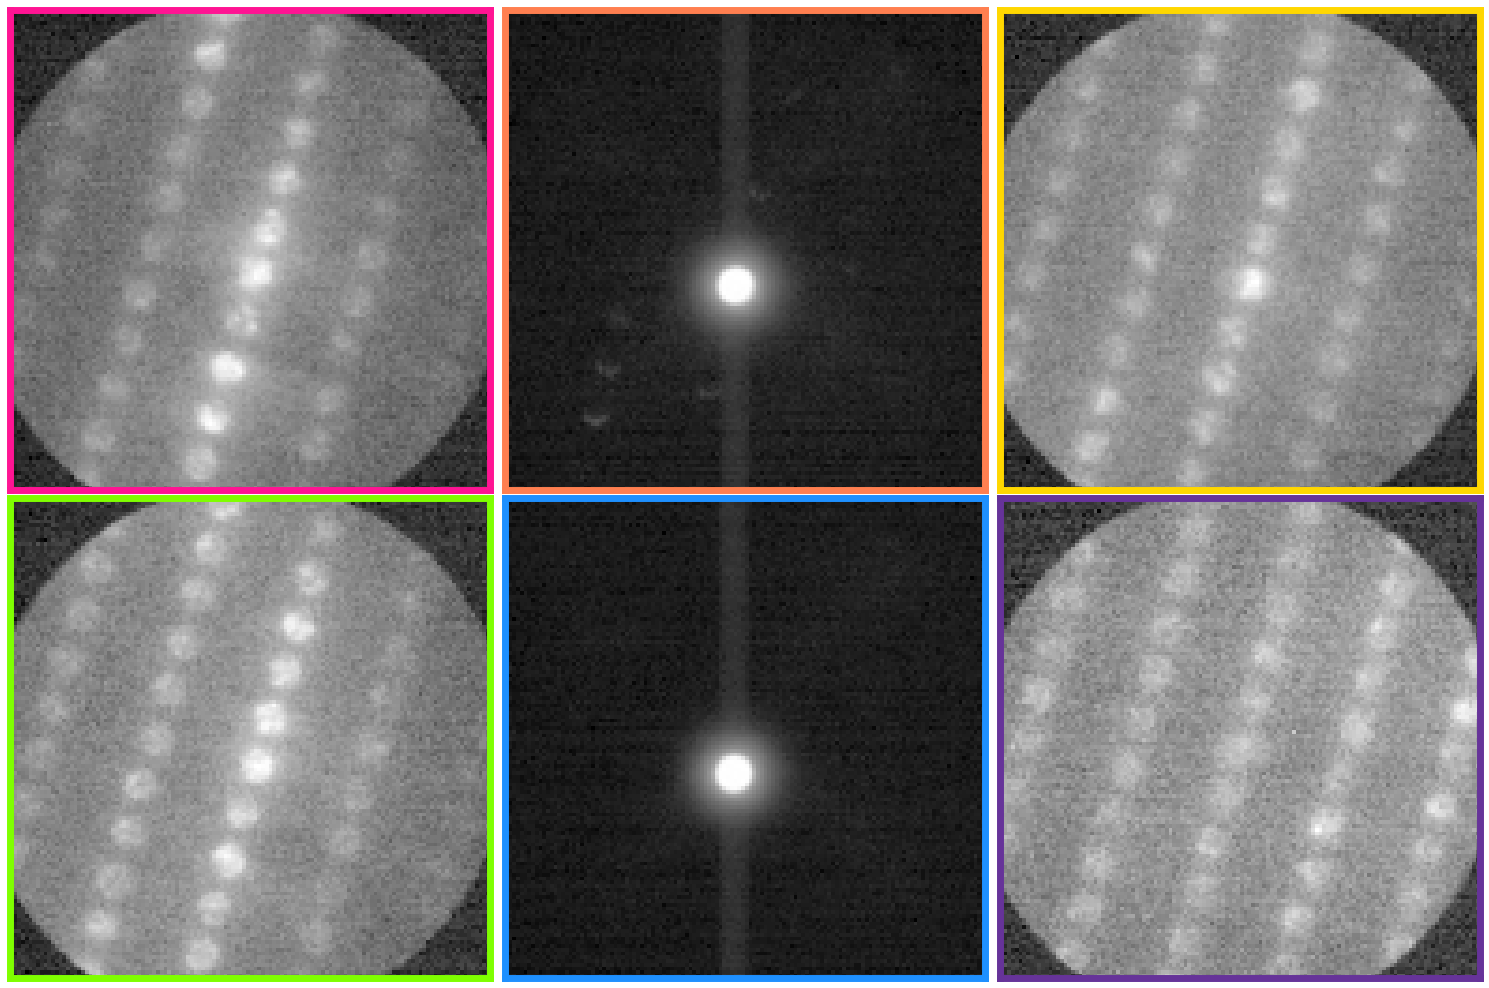

In [13]:
# Choose some diffraction patterns to use for hyperparameter tuning


rxs = 45, 25, 25, 35, 25, 66
rys = 17, 39, 14, 17, 42, 25


colors=['deeppink','coral','gold','chartreuse','dodgerblue','rebeccapurple']


py4DSTEM.visualize.show_points(
    im_adf,
    x=rxs,
    y=rys,
    pointcolor=colors,
    figsize=(4,4)
)

py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:datacube.data[rxs[i],rys[i],:,:],
    H=2, 
    W=3,
    axsize=(5,5),
    scaling='log',
    vmin=0,
    vmax=1,
    get_bordercolor = lambda i:colors[i],
)

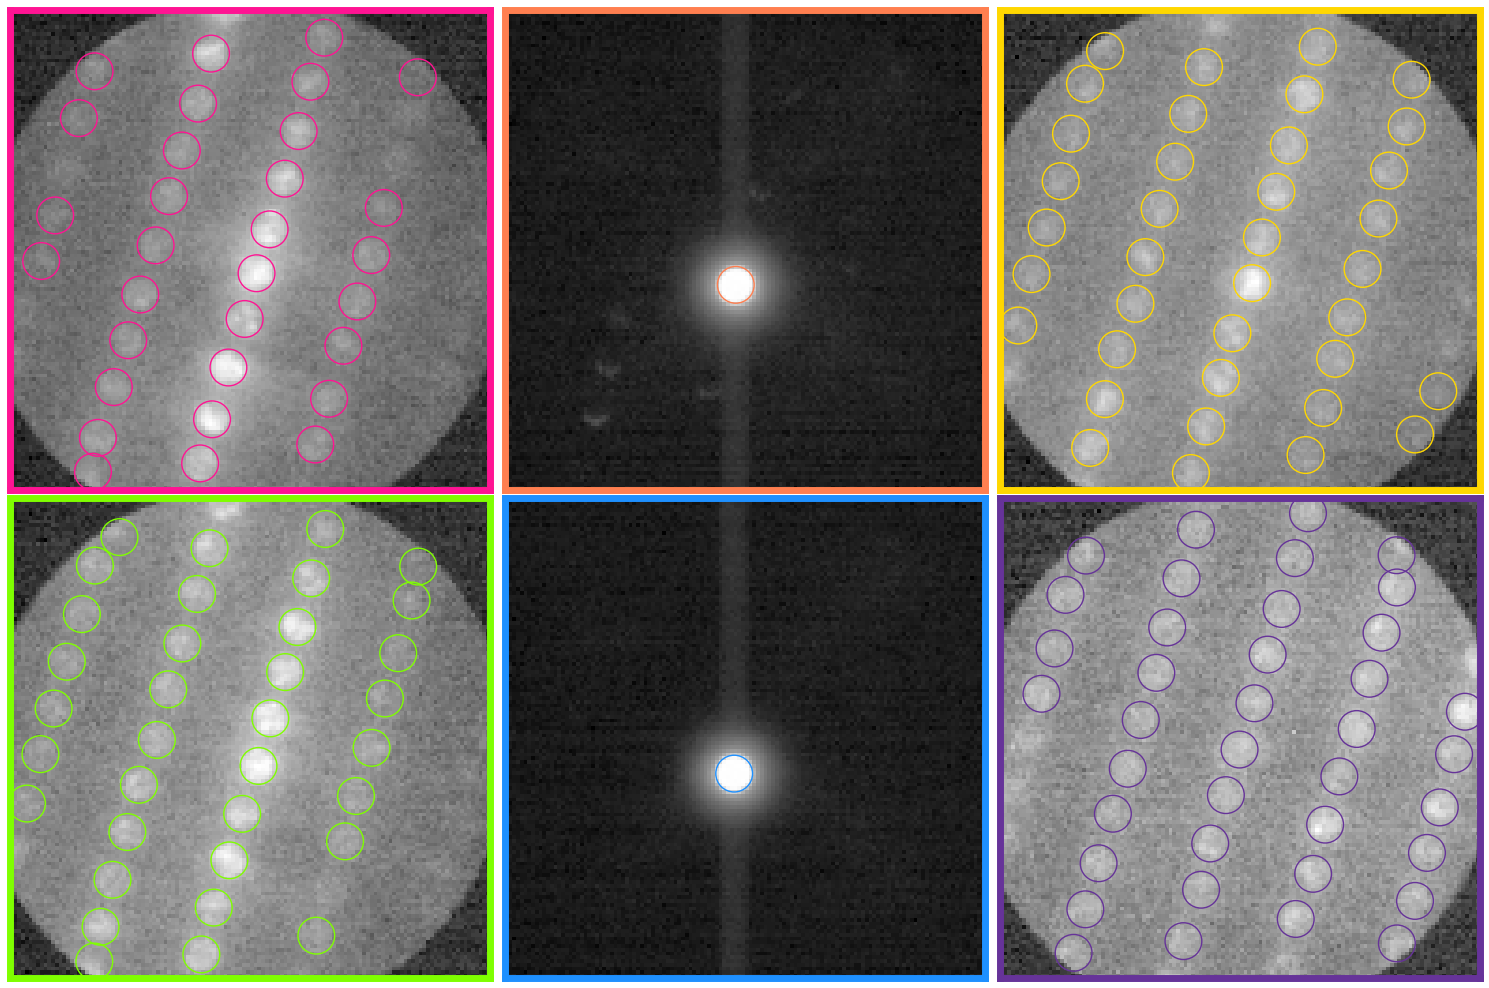

In [14]:
# Tune disk detection parameters


# disk detection parameters
detect_params = {
    'corrPower': 1.0,
    'sigma': 0,
    'edgeBoundary': 4,
    'minRelativeIntensity': 0,
    'minAbsoluteIntensity': 8,
    'minPeakSpacing': 4,
    'subpixel': 'poly',
    # 'subpixel' : 'multicorr',
    'upsample_factor': 8,
    'maxNumPeaks': 1000,
#     'CUDA': True,
}
# Note that "poly" subpixel fitting can be used to keep this tutoral fast, but "multicorr"
# is more accurate. For high precision strain mapping, subpixel="multicorr" is recommended.


# find the selected disks
disks_selected = datacube.find_Bragg_disks(
    data = (rxs, rys),
    template = probe.kernel,
    **detect_params,
)

# show
py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:datacube.data[rxs[i],rys[i],:,:],
    H=2, 
    W=3,
    axsize=(5,5),
    scaling='log',
    vmin=0,
    vmax=1,
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 700,
)

In [15]:
# Find Bragg peaks in all probe positions.


braggpeaks = datacube.find_Bragg_disks(
    template = probe.kernel,
    **detect_params,
)

Finding Bragg Disks: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.05k/4.05k [00:08<00:00, 503DP/s]


# Calibration

## Center coordinate system

(<Figure size 500x500 with 1 Axes>, <Axes: >)

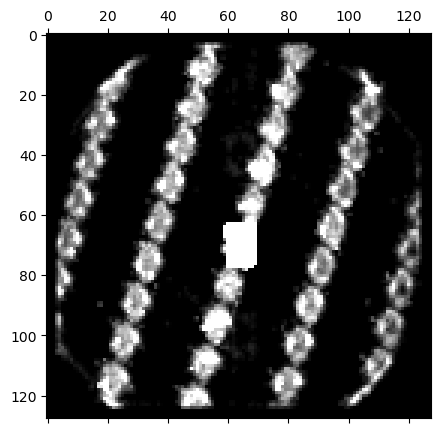

In [16]:
# Compute a Bragg vector map,
# i.e. a 2D histogram of the Bragg peak positions,
# weighted by their correlation intensities

bvm_raw = braggpeaks.histogram(mode = 'raw')

# Plot the BVM
bvm_vis_params = {
    'scaling':'power',
    'power':0.5,
    'intensity_range':'absolute',
    'vmin':0,
    'vmax':2e3
}
py4DSTEM.show(
    bvm_raw,
    **bvm_vis_params,
    returnfig = True
)

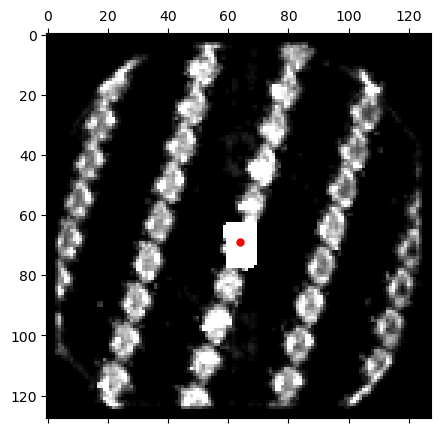

In [17]:
# Initial guess for the center position

center_guess = 69,64

py4DSTEM.show(
    bvm_raw,
    points = {'x':center_guess[0],'y':center_guess[1]},
    **bvm_vis_params,
)

/Users/Ben/work/py4dstem/code/py4DSTEM/py4DSTEM/braggvectors/braggvector_methods.py:662: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


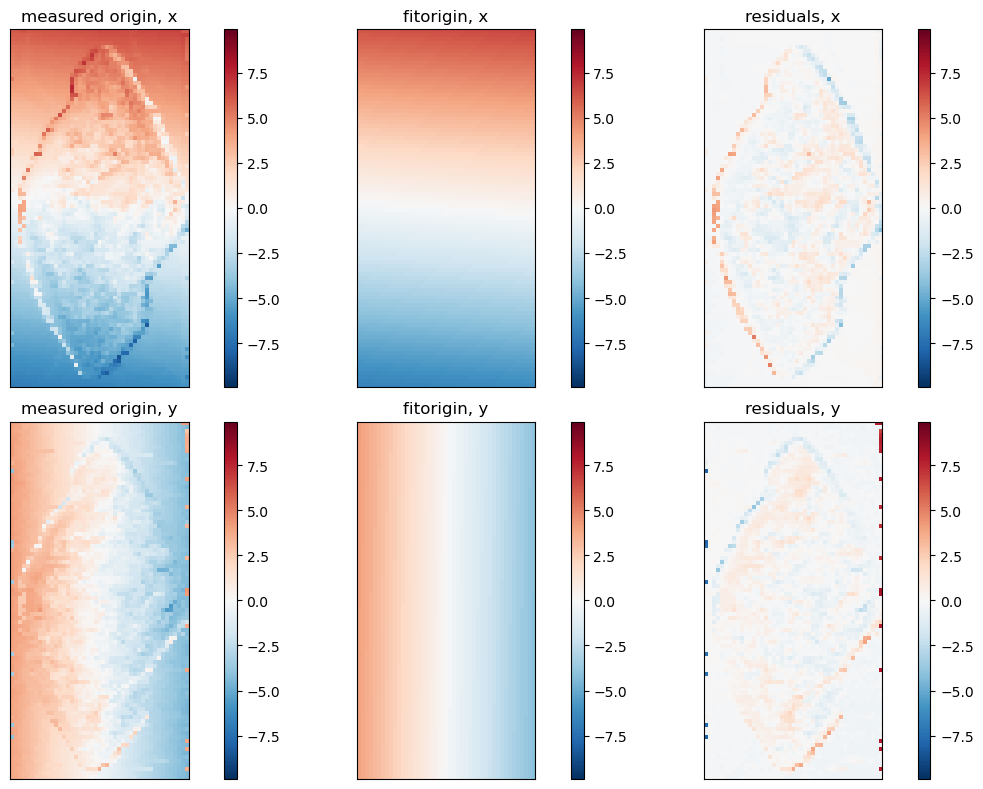

In [18]:
# Find the origin at each beam position

# measure the origin
origin_meas = braggpeaks.measure_origin( center_guess=center_guess )

# fit a 2D plane
qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = braggpeaks.fit_origin(
    ticks = False,
    axsize = (4,4),
)

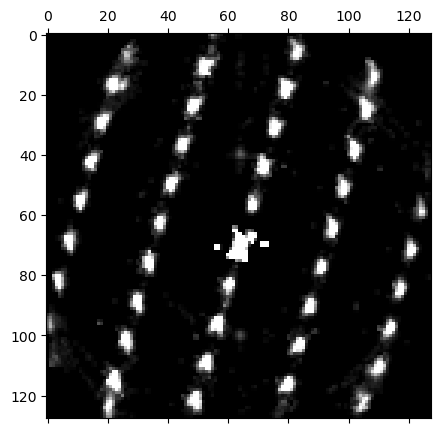

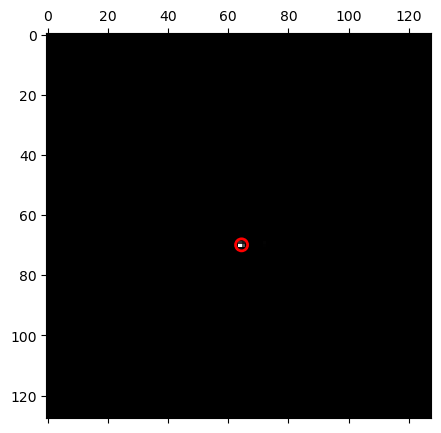

In [19]:
# Get the Bragg vector map after centering using our new origin measurements

# compute
bvm_centered = braggpeaks.histogram()

# show
py4DSTEM.show(
    bvm_centered,
    **bvm_vis_params,
)
py4DSTEM.show(
    bvm_centered,
    vmin=0,
    vmax=1,
    circle = {
        'center' : bvm_centered.origin,
        'R' : 2,
    },
)

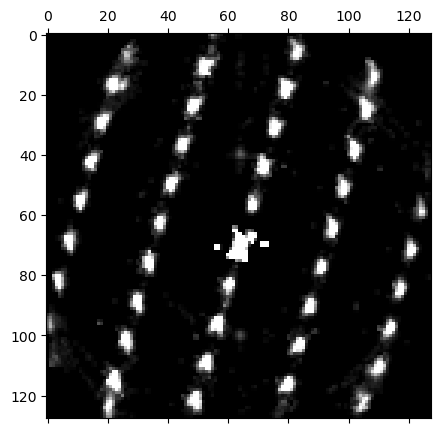

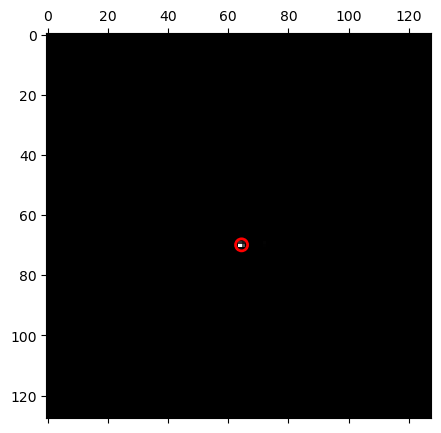

In [20]:
# Get the Bragg vector map after centering using our new origin measurements

# compute
bvm_centered_masked = braggpeaks.histogram()

# show
py4DSTEM.show(
    bvm_centered_masked,
    **bvm_vis_params,
)
py4DSTEM.show(
    bvm_centered_masked,
    vmin=0,
    vmax=1,
    circle = {
        'center' : bvm_centered_masked.origin,
        'R' : 2,
    },
)

## Ellipticity

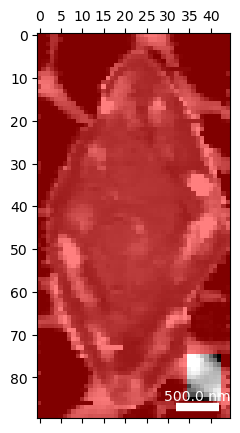

In [21]:
# Select a region of thicker lacy carbon

xlims = 75,86
ylims = 35,43

ROI_amorph = np.zeros(datacube.rshape, dtype=bool)
ROI_amorph[xlims[0]:xlims[1], ylims[0]:ylims[1]] = True

show(
    im_adf,
    mask = ROI_amorph,
    mask_color = 'r',
    mask_alpha = 0.5
)

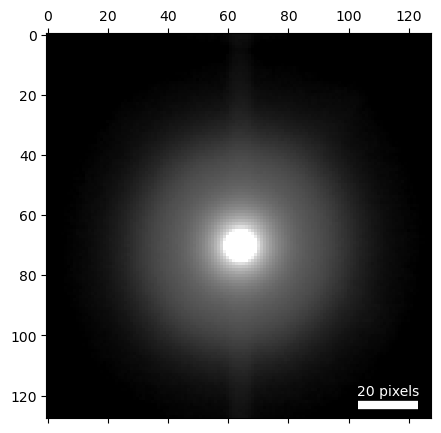

In [22]:
im_SAED_amorph = datacube.get_virtual_diffraction(
    'mean',
    mask = ROI_amorph,
    shift_center = True
)

show(
    im_SAED_amorph,
    intensity_range = 'absolute',
    vmin = 4e1,
    vmax = 8e3,
    scaling = 'log'
)

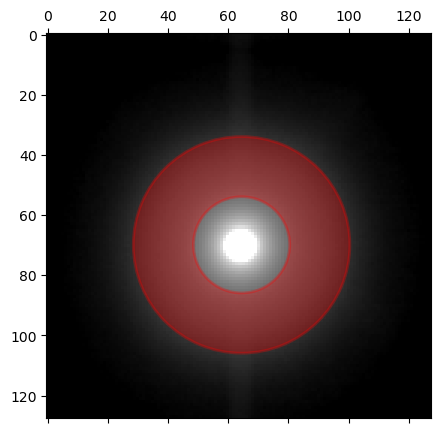

In [23]:
# Select fit radii

q_range = (16,36)

py4DSTEM.show(
    im_SAED_amorph.data,
    intensity_range = 'absolute',
    vmin = 4e1,
    vmax = 8e3,
    scaling = 'log',
    annulus={
        'center':im_SAED_amorph.calibration.get_origin_mean(),
        'radii': q_range,'fill':True,'color':'r','alpha':0.3}
)

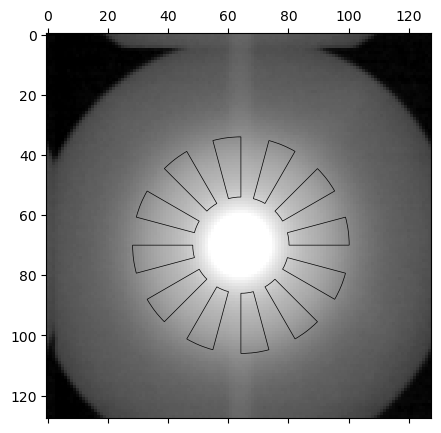

In [24]:
# Fit the amorphous halo

p_ellipse,p_dsg = py4DSTEM.process.calibration.fit_ellipse_amorphous_ring(
    data = im_SAED_amorph.data,
    center = im_SAED_amorph.calibration.get_origin_mean(),
    fitradii = q_range
)

# Show the fit
py4DSTEM.visualize.show_amorphous_ring_fit(
    im_SAED_amorph.data,
    fitradii = q_range,
    p_dsg = p_dsg,
)

In [25]:
print(p_ellipse)

(69.98889389825617, 64.18271771835121, 9.823775876618036, 9.494754360168953, -0.28982084292525473)


In [26]:
# Set the ellipse calibration

braggpeaks.calibration.set_p_ellipse(p_ellipse)
braggpeaks.setcal()

In [27]:
braggpeaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:       1
             R_pixel_size:       49.5
             Q_pixel_units:      pixels
             R_pixel_units:      nm
             QR_flip:            False
             _root_treepath:     
             qx0_meas:           2D-array
             qy0_meas:           2D-array
             origin_meas_mask:   2D-array
             qx0:                2D-array
             qx0_mean:           69.88926786129431
             qx0_shift:          2D-array
             qy0:                2D-array
             qy0_mean:           64.4084496114732
             qy0_shift:          2D-array
             a:                  9.823775876618036
             b:                  9.494754360168953
             theta:              -0.28982084292525473
)

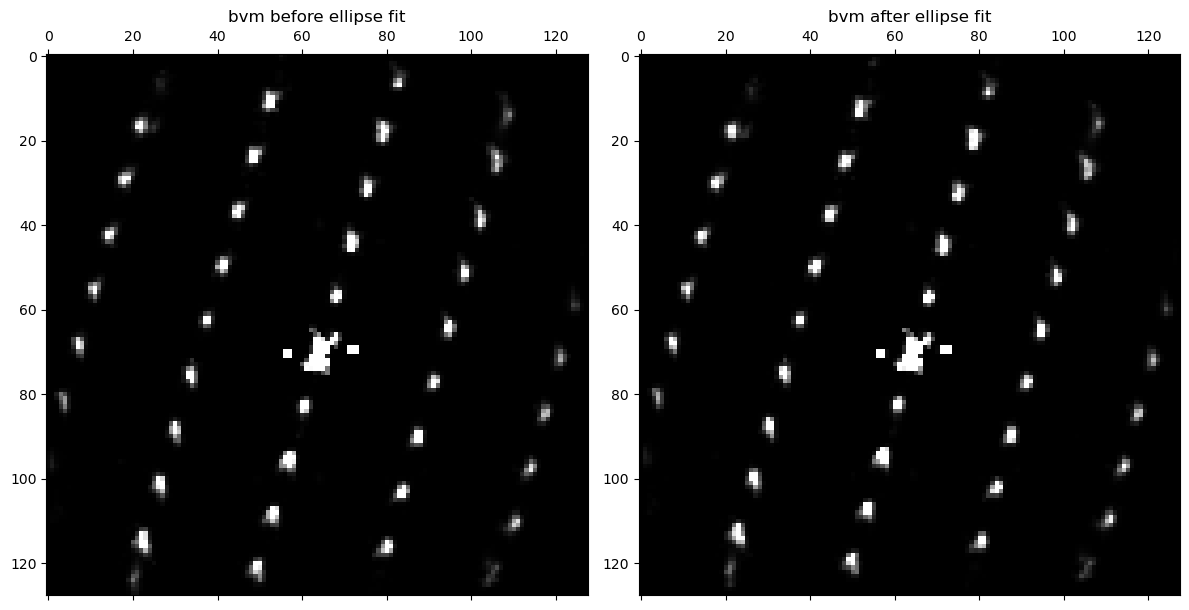

In [28]:
# Get a new corrected BVM

# compute
bvm_ellipse = braggpeaks.histogram( mode='cal' )


# show
show(
    [bvm_centered_masked, bvm_ellipse],
    vmax=0.99,
    title = ["bvm before ellipse fit", "bvm after ellipse fit"]
)

## Rotation

Measure Q/R rotation with pseudo-dpc with only the center beam

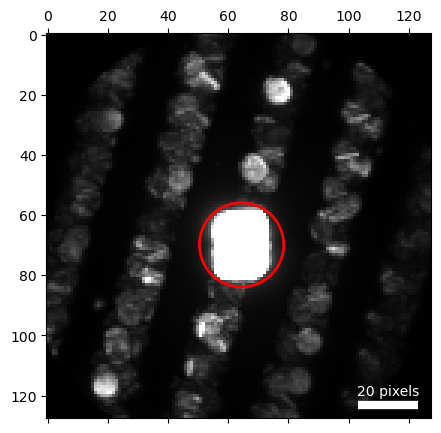

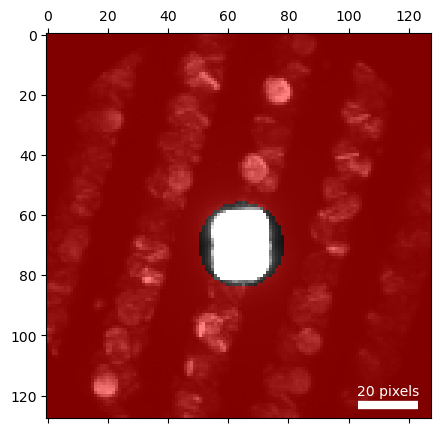

In [29]:
# make a mask

mask_radius = 14

qyy,qxx = np.meshgrid(
    np.arange(datacube.qshape[1]),
    np.arange(datacube.qshape[0]),
)
origin = braggpeaks.calibration.get_origin_mean()
qq = np.hypot(qxx-origin[0],qyy-origin[1])
mask_pseudoDPC = qq<mask_radius

show(
    dp_max,
    vmax = 0.975,
    circle = {
        'center' : braggpeaks.calibration.get_origin_mean(),
        'R' : mask_radius
    }
)
show(
    dp_max,
    vmax = 0.975,
    mask = mask_pseudoDPC,
    mask_color = 'r',
    mask_alpha = 0.5
)

/Users/Ben/work/py4dstem/code/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:417: UserWarning: Iterative reconstruction will not be quantitative unless you specify appropriate reciprocal-space calibrations
  warnings.warn(


Best fit rotation = -71 degrees.
Diffraction intensities should be transposed.


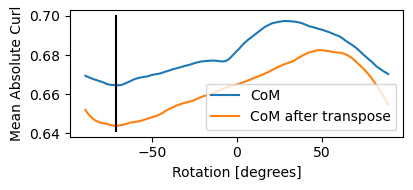

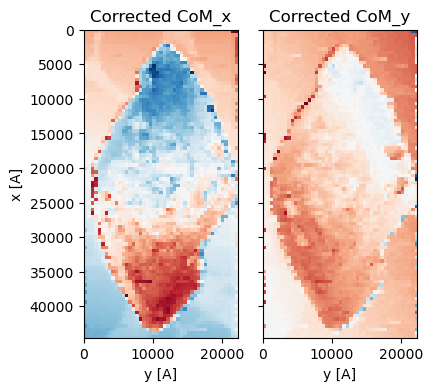

In [30]:
# perform DPC preprocessing

dpc = py4DSTEM.process.phase.DPCReconstruction(
    datacube = datacube,
).preprocess(
    dp_mask = mask_pseudoDPC,
)

In [31]:
# The rotation was measured at roughly -71 degrees and is input below manually.
# Can you find a way to confirm that this is the right rotation using only what you've seen so far in this notebook?

braggpeaks.calibration.set_QR_rotation_degrees(-71)
braggpeaks.calibration.set_QR_flip(True)
#braggpeaks.calibration.set_QR_rotation_degrees(-71)
#braggpeaks.calibration.set_QR_flip(False)
braggpeaks.setcal()

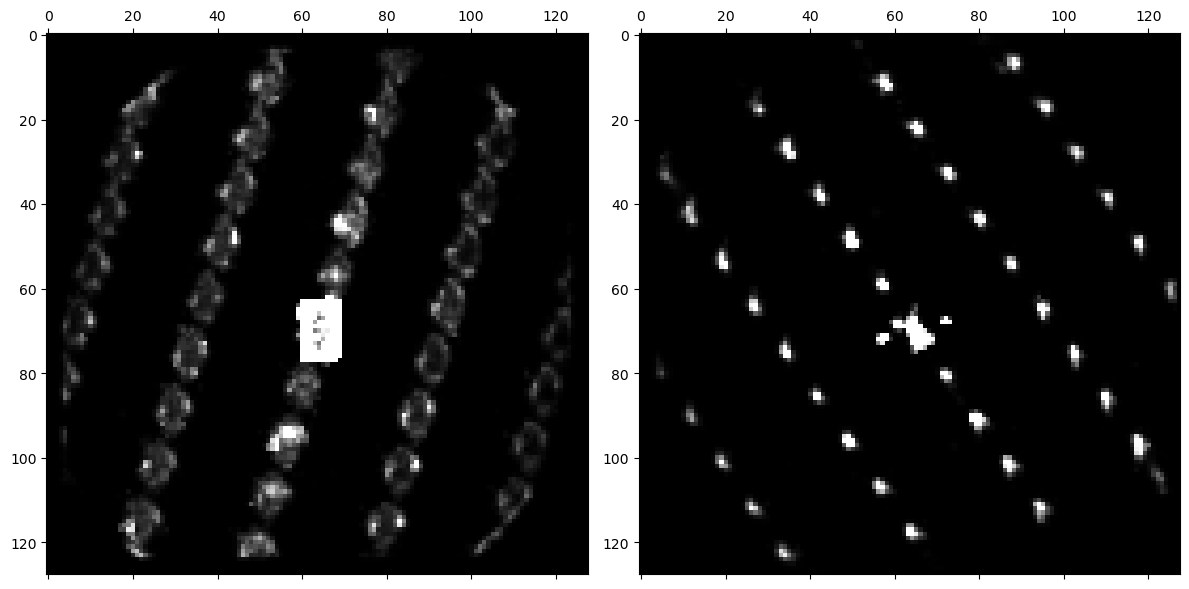

In [32]:
# Update BVM

# compute
bvm = braggpeaks.histogram( mode='cal' )


# show
show([bvm_raw, bvm],vmax=0.99)

# Strain

In [33]:
strainmap = py4DSTEM.StrainMap( braggvectors=braggpeaks )

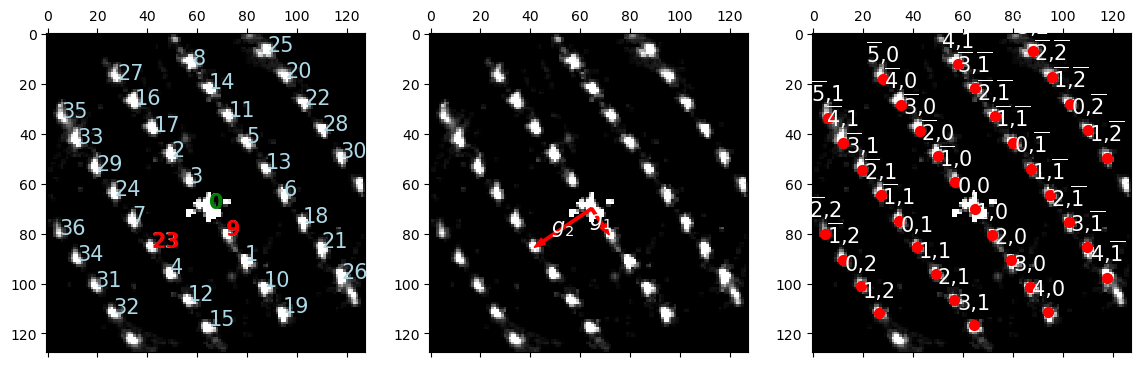

In [34]:
strainmap.choose_basis_vectors(
    minSpacing=10,
    minAbsoluteIntensity=1e3,
    maxNumPeaks=100,
    edgeBoundary=5,
    vis_params = bvm_vis_params,
    # index_g1 = 11,
    # index_g2 = 9,
)

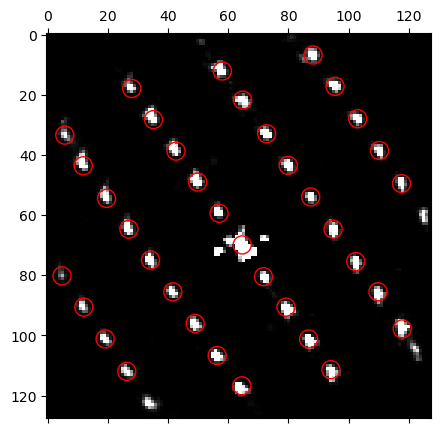

Indexing Bragg scattering: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.05k/4.05k [00:03<00:00, 1.27kDP/s]
Fitting lattice vectors: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.05k/4.05k [00:00<00:00, 4.30kDP/s]


In [35]:
strainmap.fit_basis_vectors(
    max_peak_spacing = 3,
)

Calculating strain: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.05k/4.05k [00:01<00:00, 3.87kDP/s]


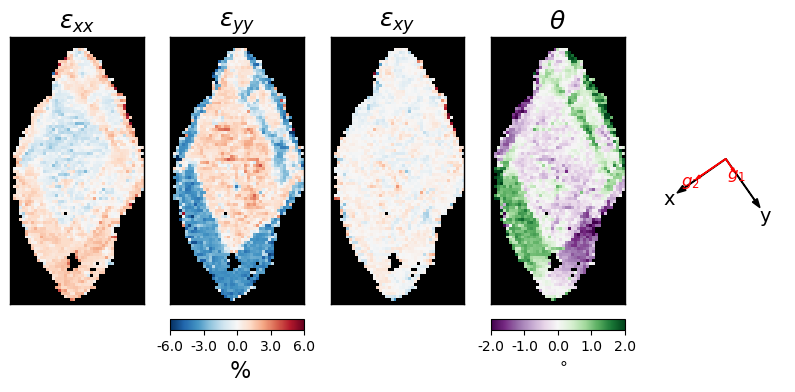

In [36]:
# strain map

strainmap.get_strain(
#    coordinate_rotation = 0,
    coordinate_rotation = -55,
#    coordinate_rotation = -100,
    layout = "horizontal",
    vrange = [-6.0, 6.0],
    vrange_theta = [-2.0, 2.0],
    # mask_color = "blue"
)

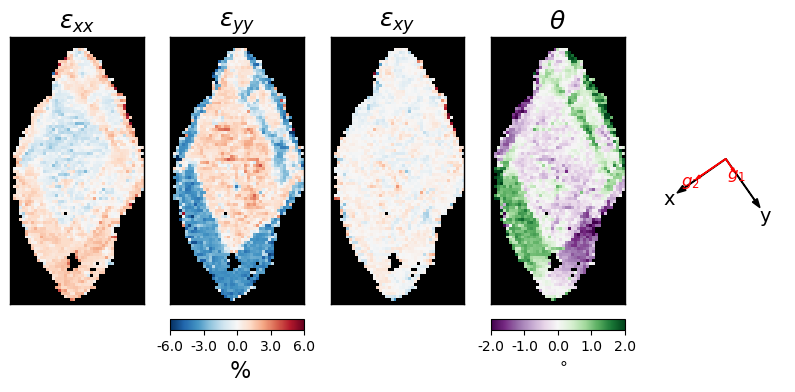

In [37]:
strainmap.show_strain(
    layout = "horizontal",
    vrange = [-6.0, 6.0],
    vrange_theta = [-2.0, 2.0],
    show_gvects = True,
)

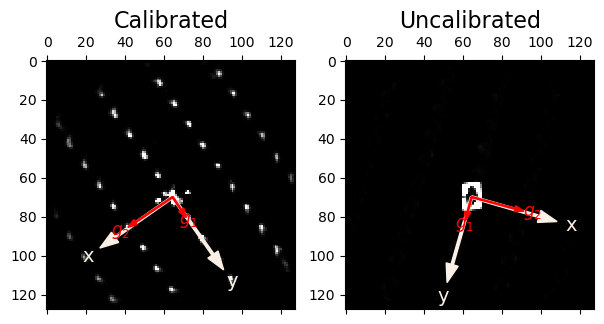

In [38]:
strainmap.show_reference_directions(
    visp_cal={
        'scaling' : 'none',
        'vmax' : 0.995
    },
    visp_uncal={
        'scaling' : 'none',
        'vmax' : 0.995
    },
    camera_length = 1.4
)

# Strain using reference $g_1$ and $g_2$ from an ROI

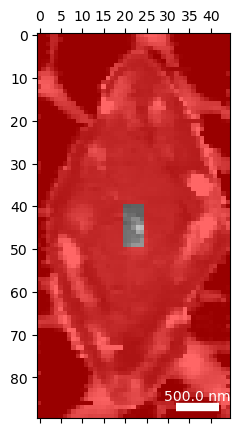

In [39]:
# Set reference region

ROI = np.zeros(braggpeaks.Rshape, dtype=bool)
ROI[40:50, 20:25] = True

show(
    im_adf,
    mask = ROI,
    mask_color='r',
    mask_alpha=0.4
)

Calculating strain: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.05k/4.05k [00:01<00:00, 3.84kDP/s]


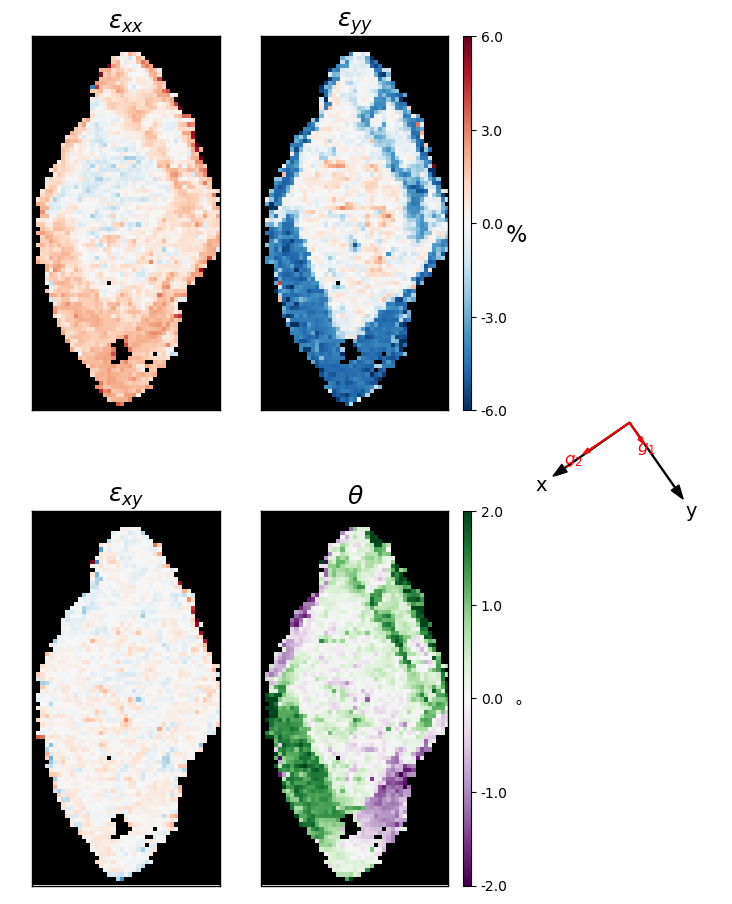

In [40]:
# strain from a region

strainmap.get_strain(
    gvects = ROI,
#    coordinate_rotation = 0,
    coordinate_rotation = -55,
#    coordinate_rotation = -100,
    layout = "square",
    vrange = [-6.0, 6.0],
    vrange_theta = [-2.0, 2.0],
)

# Strain using a manually specified reference $g_1$ and $g_2$

Calculating strain: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.05k/4.05k [00:01<00:00, 3.81kDP/s]


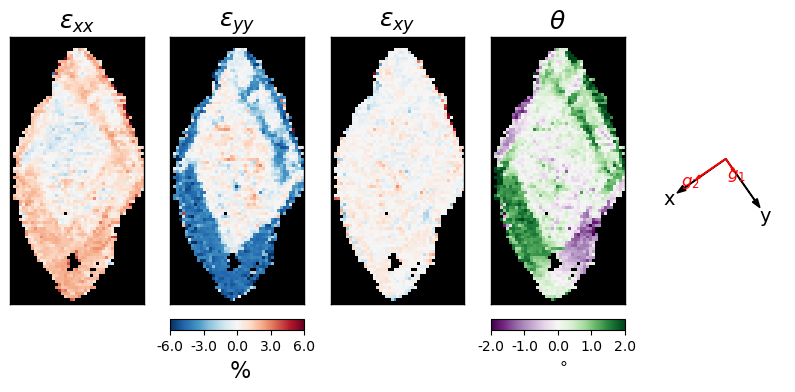

In [41]:
g1_ref, g2_ref = strainmap.get_reference_g1g2( ROI )

strainmap.get_strain(
    gvects = (g1_ref,g2_ref),
    coordinate_rotation = -55,
    layout = "horizontal",
    vrange = [-6.0, 6.0],
    vrange_theta = [-2.0, 2.0],
)